In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

#LogRegression
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score



def AddBinaryString(df,ListOfStrings):
    for string in ListOfStrings:
        dfJobs['Contains_'+string] = dfJobs['job_title_full'].str.find(string)
        dfJobs['Contains_'+string] = np.where(dfJobs['Contains_'+string]>-1.,1,0)
    return(df)

In [83]:
dfUser         = pd.read_csv("../applicant_material/user.csv") 
dfJobs         = pd.read_csv("../applicant_material/job_desc.csv") 



## Clean and prepare data

In [ ]:
##Delete strings in user_id and create concat the two dataframes
dfUser.user_id =  dfUser.user_id.apply(lambda x : int(x[1:]))
dfJobs.user_id = dfJobs.user_id.apply(lambda x : int(x[1:]))
dfAll          = pd.concat([dfUser, dfJobs], axis=1)

In [85]:
#replace all Nan with mean value
dfUserNoNan = dfUser.apply(lambda x: x.fillna(x.mean()),axis=0)
#dfAllNoNan  = dfAll.apply(lambda x: x.fillna(x.mean()),axis=0)

dfJobs  = dfJobs.apply(lambda x: x.fillna(x.mean()),axis=0)



##DataFrame jobs - Categorize!
dfJobs['Salary_Bool']  = np.where(dfJobs.salary.notnull(), 1, 0)

ListOfStrings = ['Manager','Junior','Senior', 'Lead']
dfJobs        = AddBinaryString(dfJobs,ListOfStrings)
#dfJobs['GenderRemark'] = dfJobs['job_title_full'].str.find('M/F')
#dfJobs['GenderRemark'] = np.where(dfJobs['GenderRemark']>-1.,1,0)


dfJobsDummies          = pd.get_dummies(dfJobs, columns=['company'])  
#dfJobsDummies = dfJobs
dfJobsDummies.head(n=5)    

,job_title_full,salary,user_id,Salary_Bool,Contains_Manager,Contains_Junior,Contains_Senior,Contains_Lead,company_a,company_b,company_c,company_d,company_e,company_f,company_g,company_h
0,Junior Manager Innovation Lab - France (M/F/D),51000.0,1,1,1,1,0,0,0,0,0,0,0,0,1,0
1,Junior Product Manager - Mobile,70000.0,2,1,1,1,0,0,0,1,0,0,0,0,0,0
2,Junior Brand Marketing Manager - Mobile (M/F/D),59000.0,3,1,1,1,0,0,0,0,0,0,0,0,1,0
3,Product Analyst - Pricing & Forecasting (M/F/D),NaN,4,0,0,0,0,0,0,0,0,1,0,0,0,0
4,Online Marketing Manager,64000.0,5,1,1,0,0,0,0,0,0,0,0,0,0,1


### Select features

In [ ]:
##Select features

#features     = dfUserNoNan.drop(['has_applied', 'user_id',], axis = 1)
#features.reset_index()
#features     = features.iloc[:,:]
#featureName  = 'UserFeatures'

#dfJobs       = dfAll.apply(lambda x: x.fillna(x.mean()),axis=0)
#features     = dfJobsDummies.drop(['job_title_full', 'salary','user_id',],axis = 1)
#featureName  = 'JobFeatures_Companies_Grouped_GenderRemark_SalaryBinary'          

features    = pd.concat([ dfJobsDummies.drop(['job_title_full', 'salary','user_id',],axis = 1), 
                         dfUserNoNan.drop(['has_applied','user_id',],axis = 1)], axis=1)
#featureName  = 'UserFeature+JobFeatures_GroupedJobDescFull'          


#features     = dfJobsDummies.drop(['job_title_full', 'salary','user_id',],axis = 1)
featureName  = 'User+KeywordsDescr'  

In [118]:
#Features and target variable
X, y = features, dfUserNoNan.has_applied

# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=10)

## Logistic regression  

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.601


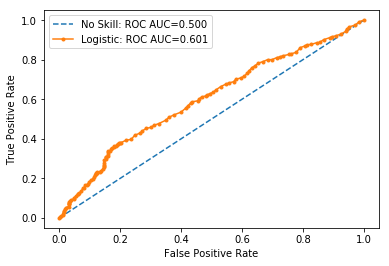

In [91]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(testy))]
# fit a model
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)
# predict probabilities
lr_probs = model.predict_proba(testX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)


# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill: ROC AUC=%.3f' % (ns_auc))
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic: ROC AUC=%.3f' % (lr_auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig('LogisticRegression'+ featureName +'.pdf')
plt.show()
plt.close()

## Support Vector machines

0.576
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.596


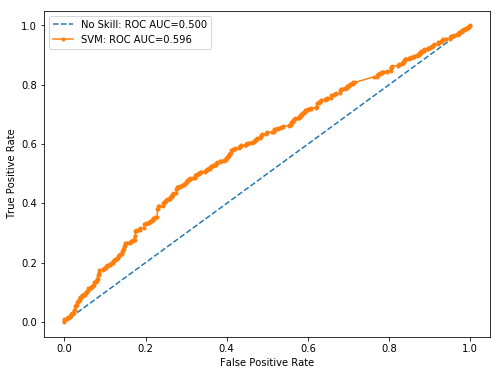

In [142]:
#trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=10)

from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm

clf = svm.SVC(kernel='rbf', C=1, probability = True).fit(trainX, trainy)
print(clf.score(testX, testy))


lr_probs = clf.predict_proba(testX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)


# plot the roc curve for the model
fig,ax = plt.subplots(figsize = (8,6))
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill: ROC AUC=%.3f' % (ns_auc))
plt.plot(lr_fpr, lr_tpr, marker='.', label='SVM: ROC AUC=%.3f' % (lr_auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig('SVM'+ featureName +'.pdf')
plt.show()
plt.close()

## Decision Tree

In [136]:
#https://www.datacamp.com/community/tutorials/xgboost-in-python

import xgboost as xgb
from sklearn.metrics import mean_squared_error

data_dmatrix = xgb.DMatrix(data=X,label=y)
xg_class = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 10, alpha = 10, n_estimators = 10)

xg_class.fit(trainX,trainy)

preds = xg_class.predict(testX)

rmse = np.sqrt(mean_squared_error(testy, preds))
print("RMSE: %f" % (rmse))


RMSE: 0.585662


In [137]:
params = {"objective":"binary:logistic",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 10, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=10,early_stopping_rounds=50,metrics="rmse", as_pandas=True, seed=123)

cv_results.head(10)


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0.491223,0.000255,0.495197,0.000251
1,0.486191,0.002507,0.492518,0.001372
2,0.479113,0.003231,0.489208,0.002398
3,0.473586,0.002638,0.486088,0.001999
4,0.468801,0.001141,0.484147,0.000841
5,0.461838,0.001941,0.481518,0.000347
6,0.457441,0.001106,0.479685,0.001460
7,0.453003,0.001845,0.478116,0.001222
8,0.449142,0.003101,0.477219,0.001241
9,0.445239,0.003606,0.475990,0.001937


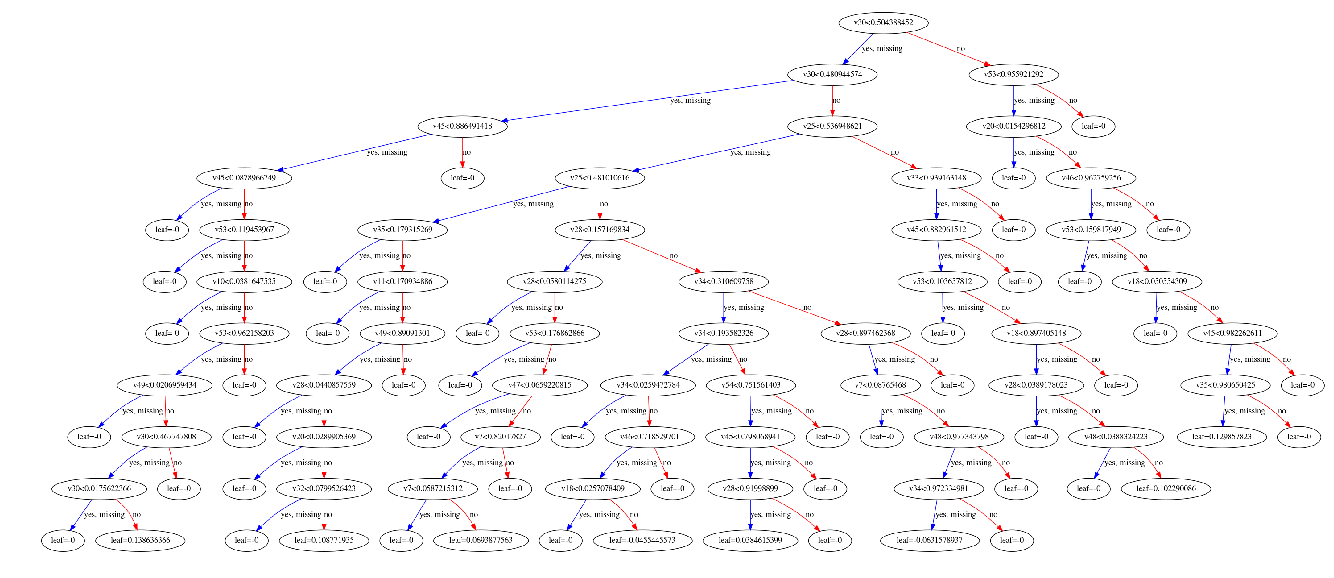

In [138]:
xg_class = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

xgb.plot_tree(xg_class,num_trees=0)
plt.rcParams['figure.figsize'] = [50, 10]
plt.savefig('Tree.pdf')
plt.show()